# New dataset

# Install libs

In [77]:
# !pip install -q gdown --upgrade
# !pip install PyYAML --upgrade
# !pip install -q translate-api
# !pip install -q pipreqsnb

pipreqs  --force /content
INFO: Successfully saved requirements file in /content/requirements.txt


# Import libs

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm.notebook import tqdm
import IPython.display as display
from PIL import Image
import pandas as pd
import pickle
import os
import yaml
import translators as ts

In [80]:
!pipreqsnb --force

pipreqs  --force /content
INFO: Successfully saved requirements file in /content/requirements.txt


# Config file

In [3]:
def read_yaml(file_path):
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

config = read_yaml('config.yml')
config

{'path': {'emotion_id_path': 'data/emotion_dict.json',
  'image_path': 'data/image/',
  'img2id_path': 'data/img2id.json',
  'test_path': 'data/e_test.json',
  'test_preprocessed_path': 'data/test.pickle',
  'train_path': 'data/e_train.json',
  'train_preprocessed_path': 'data/train.pickle',
  'val_path': 'data/e_validation.json',
  'val_preprocessed_path': 'data/val.pickle'}}

# Download dataset (gdrive links)

In [4]:
# meme imgs
!gdown --id 1GBhD3Y2WVKz-GDhR0Wy1stn5pIq21j8Y 

# img2json
!gdown --id 1xWQ0EvSU1xfPw8R39Z2NGlPNcdpWaEn0

# !emotion id
!gdown --id 1LTh7COuQ3lVAvcoJ9KGJ5R2o3Yqm_RSC

# train
!gdown --id 1Wz1-whLE1JRmDJaw09FvNl3nfrE9mQlc

# val
!gdown --id 1bSnrwCYi5LjxSfN8V0nNUqRMTvQmrkqj

# val task 1
!gdown --id 1k3HEBv0BO256AgtackTnSYRtL-oe1PML

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GBhD3Y2WVKz-GDhR0Wy1stn5pIq21j8Y
To: /content/meme_set.zip
100% 13.5M/13.5M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1xWQ0EvSU1xfPw8R39Z2NGlPNcdpWaEn0
To: /content/img2id.json
100% 10.2k/10.2k [00:00<00:00, 13.7MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: htt

In [5]:
!mkdir data

# Move data.json to folder data
!mv e_train.json data
!mv e_validation.json data
# !mv e_test.json data

# Move img2id.json to folder data
!mv img2id.json data

# Move img zip to folder data
!mv meme_set.zip data

# Move emotion dict to folder data
!mv emotion_dict.json data

mkdir: cannot create directory ‘data’: File exists


In [6]:
!unzip -q -o data/meme_set.zip -d data

# Read data

## Img to id json

In [7]:
def read_json(path):
    with open(path, "r") as read_file:
        data = json.load(read_file)
    return data

img2id_path = config['path']['img2id_path']
img2id = read_json(img2id_path)

## Train json

In [8]:
train_json = read_json(config['path']['train_path'])
val_json = read_json(config['path']['val_path'])
# test_json = read_json(config['path']['test_path'])

In [9]:
val_json['dialogue 11001']

[{'emotion_id': 5,
  'img_id': '030',
  'speaker_id': '[speaker1]',
  'txt': 'Go to work in the rain today! ! ! !'},
 {'img_id': '107', 'speaker_id': '[speaker2]', 'txt': "Haha~ I'm off today~~"},
 {'emotion_id': 29,
  'img_id': '196',
  'speaker_id': '[speaker1]',
  'txt': 'What class is tomorrow?'},
 {'speaker_id': '[speaker2]', 'txt': 'Morning shift'},
 {'speaker_id': '[speaker1]', 'txt': 'It will rain tomorrow too! Dear,'},
 {'speaker_id': '[speaker2]', 'txt': 'I know'},
 {'speaker_id': '[speaker1]', 'txt': 'It’s okay, I almost hit someone today,'},
 {'emotion_id': 7,
  'img_id': '121',
  'speaker_id': '[speaker2]',
  'txt': 'what?!What happened?'},
 {'speaker_id': '[speaker1]',
  'txt': 'The ground slipped, and the brakes could not stop, so they slipped past.'},
 {'speaker_id': '[speaker2]', 'txt': 'Oh my goodness, you be careful! ! !'},
 {'speaker_id': '[speaker1]', 'txt': 'Very careful, the ride is very slow!!'},
 {'speaker_id': '[speaker2]',
  'txt': "Well, on rainy days, I don

In [10]:
def json2df(json_data):
    dialogues = []
    for dialog_id in tqdm(json_data):
        temp = pd.DataFrame.from_dict(json_data[dialog_id], orient = 'columns')
        temp['dialogue_id'] = dialog_id

        try:
            temp = temp[['dialogue_id', 'speaker_id', 'img_id', 'emotion_id', 'txt']]
        except:
            temp['img_id'] = np.nan    #The current dialogue doesn't have img_id
            temp['emotion_id'] = np.nan

        dialogues.append(temp)

    df = pd.concat(dialogues)
    df = df.set_index('dialogue_id')
    df['img_id'] = df['img_id'].apply(lambda x: str(x) if str(x) != 'nan' else np.nan)
    df['txt'] = df['txt'].astype('str')

    return df

def convert_id2img(img2id):
    return dict((v,k) for k,v in img2id.items())

def save_pickle(df, path):
    with open(path, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(path):
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    return b

print("Converting json train/val/test to df")
train_df = json2df(train_json)
val_df = json2df(val_json)
# test_df = json2df(test_json)

Converting json train/val/test to df


  0%|          | 0/66125 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
train_df

,speaker_id,img_id,emotion_id,txt
dialogue_id,,,,
dialogue 11015,[speaker1],218,0.0,Haha. . . Don't know who i am
dialogue 11015,[speaker2],NaN,NaN,Ouyang?
dialogue 11015,[speaker1],273,9.0,Haha. . . . . Want to prompt no
dialogue 11015,[speaker2],NaN,NaN,"Give a hint,"
dialogue 11015,[speaker1],NaN,NaN,The sky of midsummer. . . . Haha
...,...,...,...,...
dialogue 61000,[speaker1],NaN,NaN,"It’s not a spare tire. Anyway, it’s been more ..."
dialogue 61000,[speaker2],NaN,NaN,"To my boyfriend, it seems that the time to say..."
dialogue 61000,[speaker1],127,24.0,So it’s all an excuse. I think it’s normal to ...


In [12]:
val_df

,speaker_id,img_id,emotion_id,txt
dialogue_id,,,,
dialogue 11001,[speaker1],030,5.0,Go to work in the rain today! ! ! !
dialogue 11001,[speaker2],107,NaN,Haha~ I'm off today~~
dialogue 11001,[speaker1],196,29.0,What class is tomorrow?
dialogue 11001,[speaker2],NaN,NaN,Morning shift
dialogue 11001,[speaker1],NaN,NaN,"It will rain tomorrow too! Dear,"
...,...,...,...,...
dialogue 28439,[speaker1],NaN,NaN,"Said you come, I absolutely accompany you to p..."
dialogue 28439,[speaker2],NaN,NaN,I'm so excited!Wait for me to work for a few m...
dialogue 28439,[speaker1],NaN,NaN,It must be necessary. I am still in Chengdu as...


# Rename images

In [13]:
config['path']['image_path']

'data/image/'

In [14]:
len(os.listdir(config['path']['image_path']))

307

In [15]:
def rename_imgs(df, path, img2id):
    df = df.copy()
    """ Đổi tên file tiếng Trung --> img id"""
    for image_file in tqdm(img2id.keys()):
        ext = image_file.split('.')[-1]
        id_name = img2id[image_file] + '.' + ext
        error_file = 0
        try:
            os.rename(path+image_file, path+id_name)    
        except FileNotFoundError:
            error_file += 1

        # Đổi img_id trong dataframe luôn
        df['img_id'] = df['img_id'].apply(lambda x: id_name if x == img2id[image_file] else x)

        # break
    print(f'num of error_file: {error_file}')

    df['img_id'] = df['img_id'].apply(lambda x: str(x) if str(x) != 'nan' else np.nan)
    return df

image_path = config['path']['image_path']
print("Renaming images + changing img_id")
train_df = rename_imgs(train_df, image_path, img2id)
val_df = rename_imgs(val_df, image_path, img2id)
# test_df = rename_imgs(test_df, image_path, img2id)
print(train_df.head())
print(val_df.head())

Renaming images + changing img_id


  0%|          | 0/307 [00:00<?, ?it/s]

num of error_file: 1


  0%|          | 0/307 [00:00<?, ?it/s]

num of error_file: 1
                speaker_id   img_id  emotion_id  \
dialogue_id                                       
dialogue 11015  [speaker1]  218.gif         0.0   
dialogue 11015  [speaker2]      NaN         NaN   
dialogue 11015  [speaker1]  273.gif         9.0   
dialogue 11015  [speaker2]      NaN         NaN   
dialogue 11015  [speaker1]      NaN         NaN   

                                             txt  
dialogue_id                                       
dialogue 11015     Haha. . . Don't know who i am  
dialogue 11015                           Ouyang?  
dialogue 11015   Haha. . . . . Want to prompt no  
dialogue 11015                      Give a hint,  
dialogue 11015  The sky of midsummer. . . . Haha  
                speaker_id    img_id  emotion_id  \
dialogue_id                                        
dialogue 11001  [speaker1]  030.jpeg         5.0   
dialogue 11001  [speaker2]  107.jpeg         NaN   
dialogue 11001  [speaker1]   196.gif        29.0   
dial

In [16]:
# save_pickle(train_df, 'input/train.pickle')
# save_pickle(val_df, 'input/val.pickle')
# save_pickle(test_df, 'input/test.pickle')

# train_df = read_pickle('input/train.pickle')
train_df

,speaker_id,img_id,emotion_id,txt
dialogue_id,,,,
dialogue 11015,[speaker1],218.gif,0.0,Haha. . . Don't know who i am
dialogue 11015,[speaker2],NaN,NaN,Ouyang?
dialogue 11015,[speaker1],273.gif,9.0,Haha. . . . . Want to prompt no
dialogue 11015,[speaker2],NaN,NaN,"Give a hint,"
dialogue 11015,[speaker1],NaN,NaN,The sky of midsummer. . . . Haha
...,...,...,...,...
dialogue 61000,[speaker1],NaN,NaN,"It’s not a spare tire. Anyway, it’s been more ..."
dialogue 61000,[speaker2],NaN,NaN,"To my boyfriend, it seems that the time to say..."
dialogue 61000,[speaker1],127.jpeg,24.0,So it’s all an excuse. I think it’s normal to ...


# Display dialogue

In [17]:
temp = train_df.loc['dialogue 40000']
temp

,speaker_id,img_id,emotion_id,txt
dialogue_id,,,,
dialogue 40000,[speaker1],227.gif,29.0,Don't talk about eating hungry here
dialogue 40000,[speaker2],NaN,NaN,Are you hungry
dialogue 40000,[speaker1],NaN,NaN,Are you swollen so know me who you are
dialogue 40000,[speaker2],NaN,NaN,"I haven't seen it, I just guessed it"
dialogue 40000,[speaker1],NaN,NaN,"Hum, don’t guess next time, so quasi-northern ..."
dialogue 40000,[speaker2],100.jpg,21.0,"Is it fun to call back and forth, be gentle"
dialogue 40000,[speaker1],NaN,NaN,Fighting is an attitude to life. If you don't ...
dialogue 40000,[speaker2],NaN,NaN,Is it love to beat or scold?
dialogue 40000,[speaker1],NaN,NaN,It's dripping haha


user1: Lao Ge, are you poisoned too?


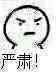

user2: Fainted by you
user1: Do I have trouble?
user2: Is there any wood?
user1: Okay, I'm desperate
user2: Super Little Dese
user1: Well, there are levels too?


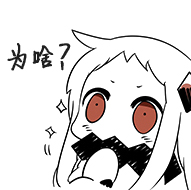

user2: It’s a lot smaller than your reality.
user1: This is a bit confusing


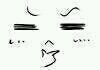

user2: Very straightforward
user1: Still don't understand


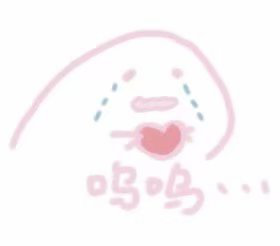

user2: I don’t know what to do, I’ve got coffee in my head


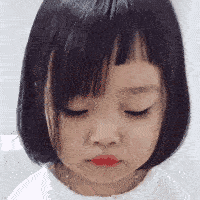

In [20]:
def display_dialogue(df, id):
    temp = df.loc[id]
    for _,row in temp.iterrows():
        img = row['img_id']
        turn = 'user1' if row['speaker_id'] == '[speaker1]' else 'user2'
        print(turn + ': ' + row['txt'])

        # try:
            # ref = id2img[str(img)]
        if str(img) != 'nan':
            display.display(Image.open(config['path']['image_path'] + f'{img}'))
        # except:
            # pass

display_dialogue(train_df, 'dialogue 1000')

# Stats + Clean

## Remove short dialogues

Phân bố Số lượt nói mỗi cuộc hội thoại

(0.0, 50.0)

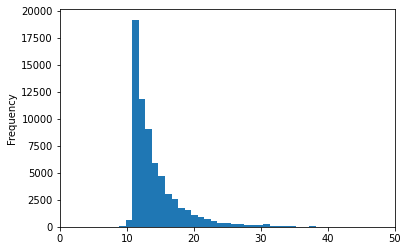

In [21]:
train_df.index.value_counts().plot(kind = 'hist', bins = 100)
plt.xlim((0, 50))

Bỏ những cuộc hội thoại có 3 lượt nói trở xuống

In [22]:
temp = (train_df.index.value_counts() < 3)
print(f"Num of len < 3: {temp.sum()}")
print(f"Percentage of len < 3: {temp.mean() * 100}")

Num of len < 3: 37
Percentage of len < 3: 0.05595463137996219


In [23]:
def remove_short_dialogue(df, num_turns = 2):
    temp = (df.index.value_counts() < num_turns)
    remove_idx = temp[temp].index
    df = df[~df.index.isin(remove_idx)]
    return df

train_df = remove_short_dialogue(train_df, 3)
val_df = remove_short_dialogue(val_df, 3)
# test_df = remove_short_dialogue(test_df, 3)
train_df

,speaker_id,img_id,emotion_id,txt
dialogue_id,,,,
dialogue 11015,[speaker1],218.gif,0.0,Haha. . . Don't know who i am
dialogue 11015,[speaker2],NaN,NaN,Ouyang?
dialogue 11015,[speaker1],273.gif,9.0,Haha. . . . . Want to prompt no
dialogue 11015,[speaker2],NaN,NaN,"Give a hint,"
dialogue 11015,[speaker1],NaN,NaN,The sky of midsummer. . . . Haha
...,...,...,...,...
dialogue 61000,[speaker1],NaN,NaN,"It’s not a spare tire. Anyway, it’s been more ..."
dialogue 61000,[speaker2],NaN,NaN,"To my boyfriend, it seems that the time to say..."
dialogue 61000,[speaker1],127.jpeg,24.0,So it’s all an excuse. I think it’s normal to ...


## \# tokens (words) per dialogue

In [24]:
train_df['token_len'] = train_df['txt'].apply(lambda x: len(x.split()))
val_df['token_len'] = val_df['txt'].apply(lambda x: len(x.split()))
# test_df['token_len'] = test_df['txt'].apply(lambda x: len(x.split()))
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,speaker_id,img_id,emotion_id,txt,token_len
dialogue_id,,,,,
dialogue 11015,[speaker1],218.gif,0.0,Haha. . . Don't know who i am,8
dialogue 11015,[speaker2],NaN,NaN,Ouyang?,1
dialogue 11015,[speaker1],273.gif,9.0,Haha. . . . . Want to prompt no,9
dialogue 11015,[speaker2],NaN,NaN,"Give a hint,",3
dialogue 11015,[speaker1],NaN,NaN,The sky of midsummer. . . . Haha,8
...,...,...,...,...,...
dialogue 61000,[speaker1],NaN,NaN,"It’s not a spare tire. Anyway, it’s been more ...",41
dialogue 61000,[speaker2],NaN,NaN,"To my boyfriend, it seems that the time to say...",13
dialogue 61000,[speaker1],127.jpeg,24.0,So it’s all an excuse. I think it’s normal to ...,20


In [25]:
token_len_dist = train_df.groupby('dialogue_id')['token_len'].sum()
token_len_dist

dialogue_id
dialogue 1        113
dialogue 10       136
dialogue 100      145
dialogue 1000      57
dialogue 10000    117
                 ... 
dialogue 9995     245
dialogue 9996      64
dialogue 9997      86
dialogue 9998     129
dialogue 9999      95
Name: token_len, Length: 66088, dtype: int64

(0.0, 1000.0)

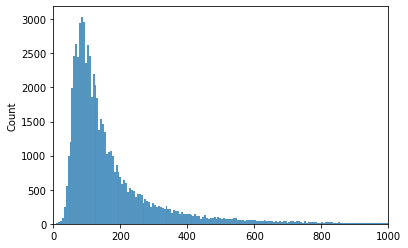

In [26]:
sns.histplot(token_len_dist.values)
plt.xlim((0, 1000))

Có nhiều đoạn hội thoại vượt cả 600 tokens, xem thử 

In [27]:
token_len_dist[token_len_dist >  600]

dialogue_id
dialogue 18095    630
dialogue 23444    602
dialogue 36275    680
dialogue 37815    749
dialogue 38246    932
                 ... 
dialogue 76855    938
dialogue 76867    919
dialogue 76873    734
dialogue 76882    981
dialogue 76944    734
Name: token_len, Length: 2200, dtype: int64

Ồ đoạn này hay phết =)) data chất lượng thật sự

user1: You are a good girl and someone who loves you more than him is waiting for you
user2: I feel very tired, I don’t want to think about the next person, and I don’t think about anything. It’s always a dream and a lie.
user1: Don’t think too much about things, let’s go with the flow, think too much, you will be very tired and suffer from severe insomnia.


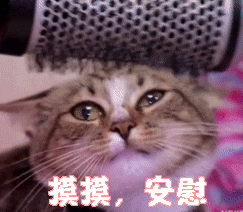

user2: At the beginning, he also said to go with the flow. There is no promise, no explanation, but I feel bored and there is no one who can’t let go. There is nothing I can’t forget. I’ll be fine. Thank you.
user1: He said let it go, what else can you do? You can only let it go, or he will be more disgusted and can only bear it in his heart and pretend not to care when seeing him is really tired
user2: Haha, the good point is that I can’t see him. The distance of more than 3,000 kilometers is the reason why he left. Maybe I will never see him again in this life.


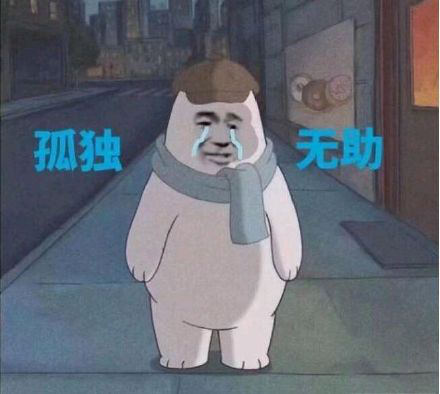

user1: I can’t see it. I have to face the person I love every day and pretend I don’t care. Space and time are both good things. Take your time
user2: Uh yeah, time is a good medicine, it will pass and cheer together


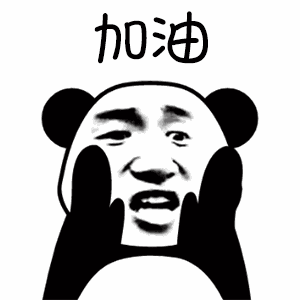

user1: Alas, he came back from a business trip this morning and took the initiative to contact me.
user2: Men like to be ambiguous, silly, children, think about it carefully, if a person can’t give you happiness, then break it off early, like me, I lied to myself, why bother when he finds his true love, he will leave you behind, isn’t it that time? Is it more painful?
user1: I know all this is because I can't control myself
user2: If you have time, you can read the story between me and him. From the first day we met to the last day, I wrote all the bits and pieces in the diary. He gave me the pledge of eachother to the cloud and smoke. After reading it, you will understand it and maybe you can let it go.
user1: Okay, I have time to see. I tried many times to give up, but every time it was a small text message from him, all his firmness disappeared.
user2: Is there no real pain? Or there is still expectation. Expectation is a terrible thing. It is disappointment or even despair. I don’t

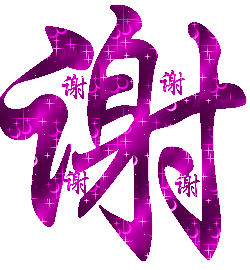

user2: En Hui Da He He
user1: Those who will pass, look forward and look happy, not cherishing you at all, it's his loss
user2: Yeah, I'll be fine, I also believe that someone will be waiting for me
user1: When you have a good mentality, you will be able to cheer up beautifully every day.


In [28]:
display_dialogue(train_df, 'dialogue 37815')

## \# emotion_id and its distribution

In [29]:
print(train_df['emotion_id'].value_counts())

0.0     30789
1.0     28821
3.0     28223
2.0     20645
8.0     13099
4.0     10678
6.0     10483
11.0    10370
10.0     9486
5.0      9469
13.0     8377
9.0      8294
7.0      8203
14.0     4274
12.0     4264
16.0     4009
23.0     3905
15.0     3718
18.0     3224
22.0     2963
19.0     2824
28.0     2801
17.0     2432
24.0     2305
27.0     2217
20.0     1844
29.0     1648
21.0     1629
25.0     1031
26.0      989
31.0      768
30.0      643
32.0      545
34.0      276
33.0      273
35.0      187
38.0      181
36.0      163
40.0      160
37.0      123
39.0      115
42.0       82
41.0       81
47.0       52
43.0       46
45.0       35
44.0       24
Name: emotion_id, dtype: int64


In [30]:
print(len(train_df['emotion_id'].value_counts()))

47


## \# turns having image

In [37]:
num_turn_images = len(train_df) - train_df['img_id'].isna().sum()
print(f'Train - Tổng lượt nói có ảnh: {num_turn_images}')
print(f'Chiếm: {num_turn_images/len(train_df) * 100:.2f} %')

Train - Tổng lượt nói có ảnh: 248678
Chiếm: 26.86 %


In [38]:
num_turn_images = len(val_df) - val_df['img_id'].isna().sum()
print(f'Val - Tổng lượt nói có ảnh: {num_turn_images}')
print(f'Chiếm: {num_turn_images/len(val_df) * 100:.2f} %')

Val - Tổng lượt nói có ảnh: 4106
Chiếm: 30.05 %


## \# turns having emotion

In [40]:
num_emotion_ids = len(train_df['emotion_id'].dropna())
print(f'Train - Tổng lượt nói có emotion: {num_emotion_ids}')
print(f'Chiếm: {num_emotion_ids/len(train_df) * 100:.2f} %')

Train - Tổng lượt nói có emotion: 246768
Chiếm: 26.66 %


In [41]:
num_emotion_ids = len(val_df['emotion_id'].dropna())
print(f'Val - Tổng lượt nói có emotion: {num_emotion_ids}')
print(f'Chiếm: {num_emotion_ids/len(val_df) * 100:.2f} %')

Val - Tổng lượt nói có emotion: 4050
Chiếm: 29.64 %


## \# Empty text turns

In [42]:
train_df[train_df['token_len'] == 0]

,speaker_id,img_id,emotion_id,txt,token_len
dialogue_id,,,,,
dialogue 28837,[speaker2],NaN,NaN,,0
dialogue 25674,[speaker1],NaN,NaN,,0
dialogue 17050,[speaker1],NaN,NaN,,0
dialogue 74098,[speaker2],285.jpg,47.0,,0


Replace an empty response with '...' =))

In [43]:
train_df.loc[train_df['token_len'] == 0, 'txt'] = '...'
val_df.loc[val_df['token_len'] == 0, 'txt'] = '...'
# test_df.loc[test_df['token_len'] == 0, 'txt'] = '...'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Replace emotion id with label

In [44]:
temp = train_df.copy()
temp

,speaker_id,img_id,emotion_id,txt,token_len
dialogue_id,,,,,
dialogue 11015,[speaker1],218.gif,0.0,Haha. . . Don't know who i am,8
dialogue 11015,[speaker2],NaN,NaN,Ouyang?,1
dialogue 11015,[speaker1],273.gif,9.0,Haha. . . . . Want to prompt no,9
dialogue 11015,[speaker2],NaN,NaN,"Give a hint,",3
dialogue 11015,[speaker1],NaN,NaN,The sky of midsummer. . . . Haha,8
...,...,...,...,...,...
dialogue 61000,[speaker1],NaN,NaN,"It’s not a spare tire. Anyway, it’s been more ...",41
dialogue 61000,[speaker2],NaN,NaN,"To my boyfriend, it seems that the time to say...",13
dialogue 61000,[speaker1],127.jpeg,24.0,So it’s all an excuse. I think it’s normal to ...,20


In [45]:
# temp['emotion_id'] = train_df['emotion_id'].fillna('')
# temp

In [46]:
emotion_ids = read_json(config['path']['emotion_id_path'])
emotion_ids

{'': 47,
 '不屑': 45,
 '不舍': 50,
 '严肃': 11,
 '乐观': 36,
 '乖巧': 8,
 '伤心': 3,
 '佩服': 15,
 '傲娇': 8,
 '关心': 29,
 '兴奋': 6,
 '内疚': 40,
 '冷静': 13,
 '加油': 10,
 '卖萌': 8,
 '厌恶': 23,
 '反感': 23,
 '可怜': 38,
 '可爱': 8,
 '吃惊': 7,
 '同情': 38,
 '呵呵': 28,
 '哀伤': 3,
 '喜悦': 0,
 '喜欢': 0,
 '嘚瑟': 9,
 '嘲笑': 4,
 '嘲讽': 23,
 '困惑': 1,
 '困扰': 3,
 '坚定': 11,
 '失望': 14,
 '失落': 3,
 '夸奖': 31,
 '夸赞': 31,
 '奇怪': 1,
 '好奇': 1,
 '委屈': 16,
 '嫉妒': 25,
 '嫌弃': 21,
 '孤独': 46,
 '安慰': 10,
 '害怕': 19,
 '害羞': 12,
 '尴尬': 20,
 '崇拜': 15,
 '崩溃': 3,
 '平淡': 34,
 '平静': 28,
 '庆幸': 22,
 '开心': 0,
 '得意': 9,
 '得瑟': 9,
 '微笑': 0,
 '忐忑': 35,
 '忧伤': 3,
 '忧愁': 3,
 '快乐': 0,
 '怀疑': 1,
 '怜惜': 38,
 '思念': 26,
 '思索': 30,
 '思考': 30,
 '恍然大悟': 32,
 '悲伤': 3,
 '悲痛': 3,
 '惊讶': 7,
 '惋惜': 24,
 '愉快': 0,
 '感叹': 32,
 '感慨': 32,
 '感激': 22,
 '感谢': 42,
 '愤怒': 5,
 '愧疚': 40,
 '懊丧': 3,
 '抱怨': 21,
 '抱抱': 0,
 '抱歉': 40,
 '担心': 29,
 '担忧': 29,
 '撒娇': 8,
 '支持': 10,
 '敬佩': 15,
 '无奈': 2,
 '无聊': 28,
 '无语': 2,
 '期待': 6,
 '期望': 0,
 '欢喜': 0,
 '欣喜': 0,
 '欣慰': 27,
 '欣赏': 0,
 '歉意': 40,
 '正经': 

1 số emotion giống nhau có cùng id, nó cùng mang 1 nghĩa nên giờ sẽ chỉ lấy cái đầu tiên

In [47]:
def remove_duplicated_emotions(emotion_ids):
    emotions = emotion_ids.values()
    result = dict()
    temp = []

    for key,value in emotion_ids.items():
        if value not in temp:
            temp.append(value)
            result[key] = value
    
    return result

emotion_ids = remove_duplicated_emotions(emotion_ids)
print(len(emotion_ids))

52


Dịch emotion qua English

In [48]:
def translate(txt):
    translation= ts.google(txt, if_use_cn_host=True, from_language='zh', to_language= 'en')
    return translation

def translate_emotion_dict(emotion_ids):
    res = dict()
    for emo in tqdm(emotion_ids):
        emotion = translate(emo).lower()
        res[emotion] = emotion_ids[emo]
    return res

emotion_ids = translate_emotion_dict(emotion_ids)
emotion_ids

  0%|          | 0/52 [00:00<?, ?it/s]

{'': 47,
 'admire': 15,
 'agree': 37,
 'anger': 5,
 'ask': 43,
 'be surprised': 7,
 'bless': 33,
 'boring': 28,
 'calm': 34,
 'calm down': 13,
 'disappointed': 14,
 'disdain': 45,
 'disgust': 23,
 'dislike': 21,
 'distressed': 3,
 'doubt': 1,
 'embarrassment': 20,
 'encourage': 10,
 'entangle': 35,
 'enthusiasm': 44,
 'envious': 25,
 'excited': 17,
 'expect': 6,
 'fear': 19,
 'feel sorry': 40,
 'grateful': 42,
 'gratified': 27,
 'gratitude': 22,
 'happy': 0,
 'in a hurry': 39,
 'laugh at': 4,
 'lonely': 46,
 'miss': 26,
 'modesty': 41,
 'naughty': 8,
 'nervous': 18,
 'not help': 50,
 'optimism': 36,
 'pass by': 48,
 'pity': 38,
 'praise': 31,
 'proud': 9,
 'regret': 24,
 'resignedly': 2,
 'science': 51,
 'serious': 11,
 'shy': 12,
 'sigh': 32,
 'sleep': 49,
 'think': 30,
 'worry': 29,
 'wronged': 16}

Thay thế emotion '' -> 'normal'

In [49]:
emotion_ids.pop('')

47

In [51]:
emotion_ids['normal'] = 47
emotion_ids

{'admire': 15,
 'agree': 37,
 'anger': 5,
 'ask': 43,
 'be surprised': 7,
 'bless': 33,
 'boring': 28,
 'calm': 34,
 'calm down': 13,
 'disappointed': 14,
 'disdain': 45,
 'disgust': 23,
 'dislike': 21,
 'distressed': 3,
 'doubt': 1,
 'embarrassment': 20,
 'encourage': 10,
 'entangle': 35,
 'enthusiasm': 44,
 'envious': 25,
 'excited': 17,
 'expect': 6,
 'fear': 19,
 'feel sorry': 40,
 'grateful': 42,
 'gratified': 27,
 'gratitude': 22,
 'happy': 0,
 'in a hurry': 39,
 'laugh at': 4,
 'lonely': 46,
 'miss': 26,
 'modesty': 41,
 'naughty': 8,
 'nervous': 18,
 'normal': 47,
 'not help': 50,
 'optimism': 36,
 'pass by': 48,
 'pity': 38,
 'praise': 31,
 'proud': 9,
 'regret': 24,
 'resignedly': 2,
 'science': 51,
 'serious': 11,
 'shy': 12,
 'sigh': 32,
 'sleep': 49,
 'think': 30,
 'worry': 29,
 'wronged': 16}

In [52]:
def rename_emotion(df, emotion_ids):
    df = df.copy()
    # Fill na
    # df['emotion_id'] = df['emotion_id'].fillna('')
    for emo in tqdm(emotion_ids):
        df['emotion_id'] = df['emotion_id'].apply(lambda x: emo if x == emotion_ids[emo] else x)
    return df

train_df = rename_emotion(train_df, emotion_ids)
val_df = rename_emotion(val_df, emotion_ids)
# test_df = rename_emotion(test_df, emotion_ids)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [53]:
train_df['emotion_id'].value_counts()

happy            30789
doubt            28821
distressed       28223
resignedly       20645
naughty          13099
laugh at         10678
expect           10483
serious          10370
encourage         9486
anger             9469
calm down         8377
proud             8294
be surprised      8203
disappointed      4274
shy               4264
wronged           4009
disgust           3905
admire            3718
nervous           3224
gratitude         2963
fear              2824
boring            2801
excited           2432
regret            2305
gratified         2217
embarrassment     1844
worry             1648
dislike           1629
envious           1031
miss               989
praise             768
think              643
sigh               545
calm               276
bless              273
entangle           187
pity               181
optimism           163
feel sorry         160
agree              123
in a hurry         115
grateful            82
modesty             81
normal     

In [54]:
val_df['emotion_id'].value_counts()

distressed       483
doubt            458
resignedly       376
happy            368
naughty          281
laugh at         200
expect           189
encourage        176
anger            164
be surprised     144
proud            139
serious           87
calm down         84
disappointed      77
admire            71
disgust           65
nervous           62
excited           56
regret            54
wronged           53
dislike           52
shy               50
worry             43
envious           41
embarrassment     32
gratified         32
fear              29
boring            26
sigh              21
gratitude         21
praise            18
calm              17
optimism          17
miss              16
think              8
bless              7
pity               6
feel sorry         5
agree              4
entangle           4
in a hurry         4
ask                3
grateful           3
disdain            2
enthusiasm         2
Name: emotion_id, dtype: int64

In [67]:
save_pickle(train_df, config['path']['train_preprocessed_path'])
save_pickle(val_df, config['path']['val_preprocessed_path'])
# save_pickle(test_df, config['path']['test_preprocessed_path'])

In [70]:
# %mkdir code
# %mv -f config.yml code
# %mv -f data code
# %mv -f requirements.txt code

In [ ]:
# !zip -r code.zip code/